In [41]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [42]:
df = pd.read_csv('data/usinflation.csv')

df.head()

,year,month,inflation_1
0,1950,2,-3.552289
1,1950,3,5.247540
2,1950,4,1.692860
3,1950,5,5.064298
4,1950,6,6.719322


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         491 non-null    int64  
 1   month        491 non-null    int64  
 2   inflation_1  491 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 11.6 KB


In [44]:
# Combine year and month into a date (assuming the day is always the first of the month)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date as the index
df.set_index('date', inplace=True)

# Drop the year and month columns if you don't need them
df.drop(columns=['year', 'month'], inplace=True)

# Display the dataframe
df.head()

,inflation_1
date,
1950-02-01,-3.552289
1950-03-01,5.247540
1950-04-01,1.692860
1950-05-01,5.064298
1950-06-01,6.719322


In [45]:
# Calculate the changes in inflation
df['inflation_change'] = df['inflation_1'].diff()
# Check for NaN values in the 'inflation_change' column and drop them
df.dropna(subset=['inflation_change'], inplace=True)

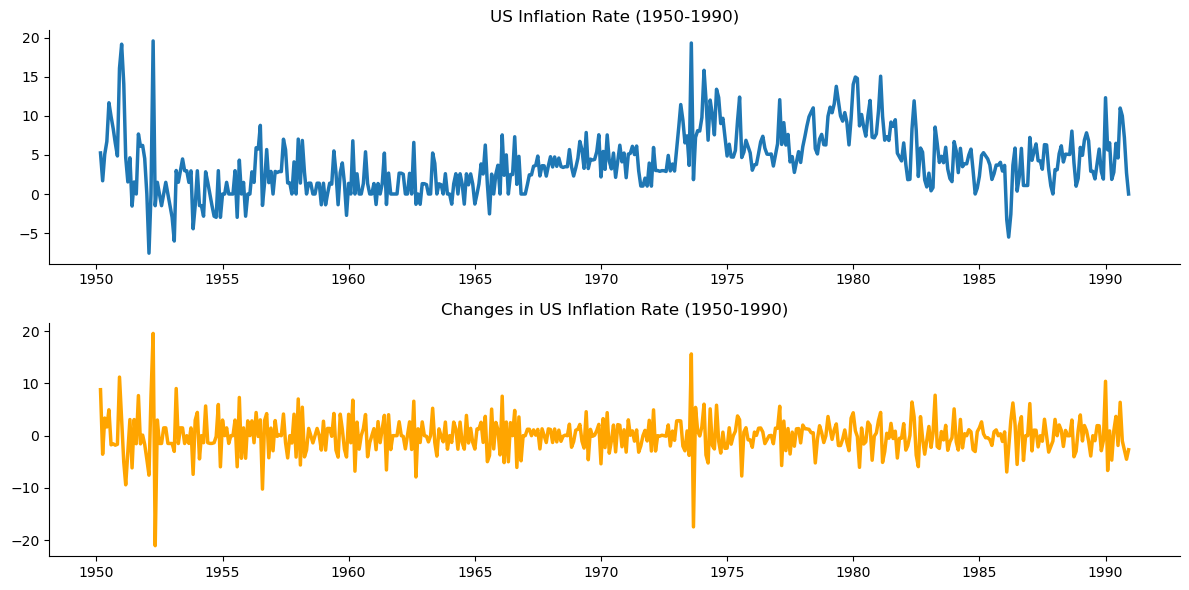

In [46]:
# Plotting the inflation and inflation changes
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(df['inflation_1'], label='Inflation')
plt.title('US Inflation Rate (1950-1990)')
plt.subplot(212)
plt.plot(df['inflation_change'], label='Changes in Inflation', color='orange')
plt.title('Changes in US Inflation Rate (1950-1990)')
plt.tight_layout()
plt.show()

In [47]:
# stationarity check
ADF_result = adfuller(df['inflation_1'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.4906814873614116
p-value: 0.11775811400552683


In [48]:
# stationarity check
ADF_result = adfuller(df['inflation_change'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.946906564715276
p-value: 2.193240845644712e-07


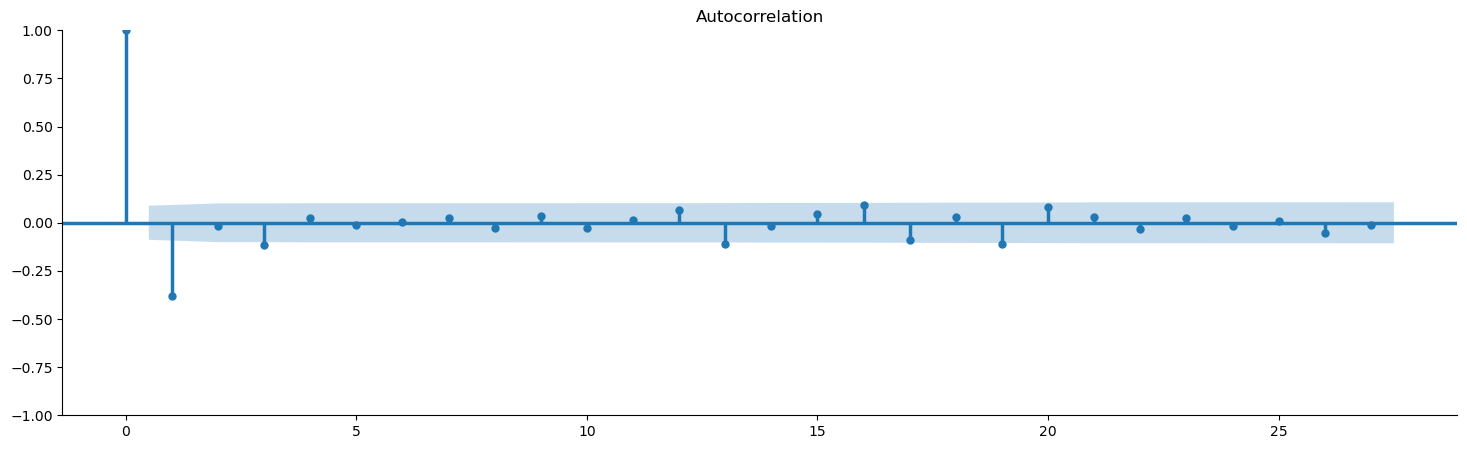

In [49]:
plot_acf(df['inflation_change'])
plt.show()

In [50]:
df_diff = pd.DataFrame({'inflation_change': df['inflation_change']})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]


print(len(train))
print(len(test))

441
49


In [51]:
TRAIN_LEN = len(train)
HORIZON = len(test)

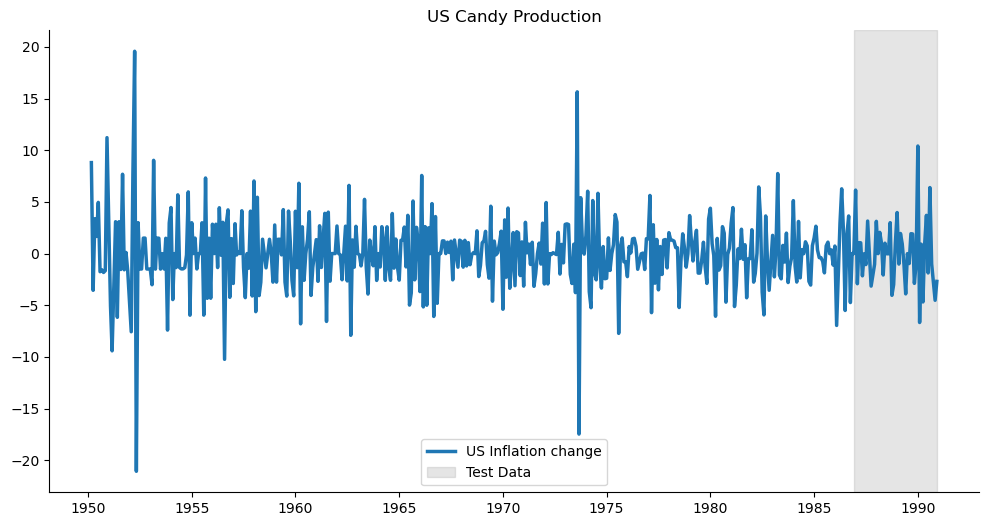

In [52]:
test_start = df.index[TRAIN_LEN]  # Start of the test data
test_end = df.index[-1]  # End of the test data


# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['inflation_change'], label='US Inflation change')

# Highlight the test data range
plt.axvspan(test_start, test_end, color='#808080', alpha=0.2, label="Test Data")

plt.title('US Candy Production')
plt.legend()
plt.show()

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = ARIMA(df[:i], order=(0,0,1))
            res = model.fit()
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [56]:
pred_df = test.copy()


WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,inflation_change,pred_mean,pred_last_value,pred_MA
date,,,,
1986-12-01,-0.000876,0.010524,-0.000989,0.853834
1987-01-01,6.138917,0.010498,-0.000876,0.664896
1987-02-01,-2.918032,0.024332,6.138917,-4.299226
1987-03-01,1.055680,0.017705,-2.918032,-1.080181
1987-04-01,1.041192,0.020038,1.055680,-1.663172


In [ ]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the size for better visibility

# Plot the original inflation change data
# ax.plot(df['inflation_change'], label='Inflation Change', color='orange', linewidth=2)

# Plot the actual inflation change values from pred_df
ax.plot(pred_df['inflation_change'], 'b-', label='Actual Inflation Change', linewidth=2)

# Plot the predicted values based on MA(1) model from pred_df
ax.plot(pred_df['pred_MA'], 'k--', label='Predicted Inflation (MA(1))', linewidth=2)

# Optional: Plot other predictions (e.g., mean or last value) if desired
ax.plot(pred_df['pred_mean'], 'g:', label='Predicted Mean', linewidth=2)
ax.plot(pred_df['pred_last_value'], 'r-.', label='Predicted Last Value', linewidth=2)

# Adding title and labels to make the plot more readable
ax.set_title('Inflation Change - Actual vs Predicted (MA(1))', fontsize=16)
ax.set_xlabel('Time (Months)', fontsize=12)
ax.set_ylabel('Inflation Change (%)', fontsize=12)

# Adding a legend to distinguish between the different series
ax.legend(loc='upper left', fontsize=12)

# Optional: Grid for better readability
ax.grid(True)

# Show the plot
plt.tight_layout()  # To make sure everything fits nicely in the figure
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['inflation_change'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['inflation_change'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['inflation_change'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

In [ ]:

# MSE values

# Store in a list
mse_values = [mse_mean, mse_last, mse_MA]

methods = ['Mean Prediction', 'Last Value Prediction', 'MA(1) Prediction']

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, mse_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', ha='center', fontsize=10)

# Set labels and title
ax.set_xlabel('Prediction Method', fontsize=12)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax.set_title('Comparison of MSE for Prediction Methods', fontsize=14)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()